# German traffic sign classification in Tensorflow
The goal of this project is to develop a modified `LeNet` architecture to classify German traffic signs in `Tensorflow` (for `Python`). Furthermore, we aim to make this code as general as possible so that it can easily be extended and adapted for other image processing projects and pipelines. Therefore the reusable components have been put into a separate file **`layers.py`**, while the code specific to traffic sign detection is contained in this file. 

## Building blocks
### Layers
Neural networks are typically defined in terms of their layers, where each layer is responsible for two things:
1. Mapping input tensors to output tensors
1. Computing `L1` and `L2` norms of its weights (and biases).

Hence the **`layers`** package defines the following base class:


In [1]:
import tensorflow as tf

class Layer:
    def __init__(self, operation=lambda x:x):
        self.operation  = operation

    def output(self, input):
        return self.operation(input)

    def L1(self):
        return tf.constant(0.0)

    def L2(self):
        return tf.constant(0.0)

> The reason we highlight the second aspect is that it is fairly common to use the `L1` or `L2` norm of a network's weights (and biases) as a regularization term in the cost function. Therefore, by forcing the layers to compute their norms themselves, we can write much cleaner, more modular code.

A simple example of how you can extend this base `Layer` class is given by the `FlattenLayer` class, which (as the name implies) simply flattens the input tensor into a single 1D vector:

In [2]:
class FlattenLayer(Layer):
    def __init__(self):
        super().__init__(lambda x: tf.contrib.layers.flatten(x))

An important thing to note about the `Layer` and `FlattenLayer` classes is that they do not define any internal weights or biases. Hence their `L1` and `L2` norms are 0. Conversely, many layers would more appropriately be represented as subclasses of the `WeightedLayer` class, which allocates random weights and biases according to a given shape tuple:

In [3]:
class WeightedLayer(Layer):
    def __init__(self, weight_shape, name="weighted_layer", mean=0, stddev=0.1):
        self.W = tf.Variable(tf.truncated_normal(shape=weight_shape, mean=mean, stddev=stddev), name=name + "_weights")
        self.b = tf.Variable(tf.zeros(weight_shape[-1]), name=name + "_bias")
        # Subclasses should override self.operation after calling super().__init__

    def L1(self):
        return tf.norm(self.W, ord=1) + tf.norm(self.b, ord=1)

    def L2(self):
        return tf.sqrt(tf.norm(self.W) ** 2 + tf.norm(self.b) ** 2)

For example, `FullLayer` is a subclass of `WeightedLayer` which also allows the user to specify an `activation` function:

In [4]:
class FullLayer(WeightedLayer):
    def __init__(self, weight_shape, name="full_layer", mean=0, stddev=0.1, activation=tf.nn.relu):
        super().__init__(weight_shape=weight_shape, name=name, mean=mean, stddev=stddev)
        self.operation = lambda x: activation(tf.matmul(x, self.W) + self.b)

Similarly, a convolution layer is a `WeightedLayer` which chains together a convolution operation, activiation function, and max-pooling operation:

In [5]:
class ConvLayer(WeightedLayer):
    def __init__(self, weight_shape=(5, 5, 1, 6), name="conv_layer", mean=0, stddev=0.1, pool_size=[1, 2, 2, 1], pool_stride=[1, 2, 2, 1], activation=tf.nn.relu):
        super().__init__(weight_shape=weight_shape, name=name, mean=mean, stddev=stddev)
        convolver      = lambda x: tf.nn.conv2d(x, self.W, strides=[1, 1, 1, 1], padding='VALID') + self.b
        pooler         = lambda y: tf.nn.max_pool(y, ksize=pool_size, strides=pool_stride, padding='VALID')
        self.operation = lambda z: pooler( activation( convolver( z )) )

From these basic building blocks, you should be able to easily and intuitively construct many neural networks found in the literature.

### LeNet
`LeNet` is one of the most famous convolutional neural networks. We use a modified form here because, although it was developed for the **`MNIST`** dataset, the general architecture has been show to be quite successful for a variety of image classification problems. 

> Note that we are using the LeNet architecture, not the specific neural network trained for the MNIST dataset. In principle, you can use the LeNet archiecture for any image classification problem ; You just need to train the architecture to the specific problem at hand. That is precisely what we will do here. 

The `LeNet` architecture can be represented as a chain of the building blocks described above. Specifically, the basic `LeNet` architecture looks like:

In [6]:
class LeNet:

    def __init__(self, x, y, depths=[10, 20, 200, 100]):
        '''
        :param x: A tf.placeholder for the input images of size

                (None) X (image width) X (image height) X (image channels)

        :param y: A tf.placeholder for one-hot encoded annotations

                (None) X (# of image classes)
        '''

        # Create all of the layers
        m = x.get_shape().as_list()[-1]

        x = ConvLayer(name="layer_1", weight_shape=(5, 5,     m    , depths[0])).output(x)
        x = ConvLayer(name="layer_2", weight_shape=(5, 5, depths[0], depths[1])).output(x)
        x = FlattenLayer().output(x)

        n = x.get_shape().as_list()[-1]

        x = FullLayer(name="layer_3", weight_shape=(    n    , depths[2])).output(x)
        x = FullLayer(name="layer_4", weight_shape=(depths[2], depths[3])).output(x)
        x = FullLayer(name="layer_5", weight_shape=(depths[3], y.get_shape().as_list()[1]), activation=lambda q: q).output(x)

        # Give names to a bunch of values that we will use during evaluation
        self.logits         = x
        self.y              = y
        self.predictions    = tf.argmax(self.logits, axis=1)
        self.accuracy       = tf.reduce_mean(tf.cast(tf.equal(self.predictions, tf.argmax(y, axis=1)), tf.float32))
        self.cross_entropy  = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=y)
        self.cost           = tf.reduce_mean(self.cross_entropy)

    ...

The beauty of defining `LeNet` like this is that we do not have to hardcode any of the problem-specific details. For instance, the traditional `LeNet` architecture was developed for the `MNIST` problem, meaning that it was designed to take in 32x32 pixel images and return a prediction in the range [0,9]. However, in the above architecture, you will see that those details are NOT hardcoded. Instead, we handle this by forcing the `LeNet` architecture to take placeholders for the images and annotations as inputs, and infer dimensions from those values. Specifically, given training data `(X_train,y_train)`, we can create a `LeNet` like this:


    x_shape = list(X_train.shape)
    x_shape[0] = None
    x = tf.placeholder(tf.float32, x_shape)

    y_shape = list(y_train.shape)
    y_shape[0] = None
    y = tf.placeholder(tf.float32, y_shape)

    lenet = LeNet(x, y)

In fact, the `LeNet` defined above is just a simplified version of the one defined in the `layers` package, with the primary distinction being that the `LeNet` in the `layers` package also utilizes *dropout*. *Dropout* is a new and widely successful form of regularization. Whereas `L1` or `L2` norms have been traditionally used for regularization, we use dropout to achieve the same effect. Hence the `LeNet` class in the `layers` package implements dropout between the 3rd and 4th layers, and between the 4th and 5th layers:

In [7]:
    class LeNet:

        def __init__(self, x, y, depths=[10, 20, 200, 100]):

            self.dropout = tf.placeholder(tf.float32)
            ...

            x = FullLayer(name="layer_3", weight_shape=(    n    , depths[2])).output(x)
            x = tf.nn.dropout(x, keep_prob=self.dropout) # NEW!!!
            x = FullLayer(name="layer_4", weight_shape=(depths[2], depths[3])).output(x)
            x = tf.nn.dropout(x, keep_prob=self.dropout) # NEW!!!
            x = FullLayer(name="layer_5", weight_shape=(depths[3], y.get_shape().as_list()[1]), activation=lambda q: q).output(x)

            ...

To create and train a `LeNet` model on the training data `(X_train,y_train)`, you can use the following code snippet:

    x_shape = list(X_train.shape)
    x_shape[0] = None
    x = tf.placeholder(tf.float32, x_shape)

    y_shape = list(y_train.shape)
    y_shape[0] = None
    y = tf.placeholder(tf.float32, y_shape)

    lenet = LeNet(x, y)
    trainer=tf.train.AdamOptimizer(learning_rate=0.001).minimize(lenet.cost)
    lenet.train(X_train, y_train, trainer)

The results of training will be discussed in the coming sections. But first... let's talk about the data...'

## Loading The Data
The baseline data has been pre-pickled, and is [available here](https://github.com/mholzel/signs/releases/download/data/signs.zip). You should download this zip file, unpack it, and copy all of its contents (**`train.p`**, etc.) into the subfolder **`data/original/`**. The pickled datasets (`*.p`) are dictionaries with 2 key/value pairs:

1. **`features`** is a 4D array containing raw pixel data of the traffic sign images. This array is of shape: `(# of examples, image width, image height, image channels)`.
1. **`labels`** is a 1D array containing the label/class id of the traffic sign. 

The file **`signnames.csv`** contains the descriptions of each of the sign categories. For instance, 

    Category 33 : Turn right ahead

In [8]:
# Visualizations will be shown in the notebook.
%matplotlib inline

# Toggle plotting
plotting = True

import csv, pickle
import numpy as np

def loadfrom( folder = 'data/original/' ):
    training_file   = folder + 'train.p'
    validation_file = folder + 'valid.p'
    testing_file    = folder + 'test.p'

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test  = pickle.load(f)

    def split( data ):
        return data['features'], data['labels']

    X_train, y_train = split(train)
    X_valid, y_valid = split(valid)
    X_test, y_test   = split(test)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [9]:
# Load pickled data
X_train, y_train, X_valid, y_valid, X_test, y_test = loadfrom()

# Save copies for later
X_train_original = np.copy(X_train)
X_valid_original = np.copy(X_valid)
X_test_original  = np.copy(X_test)
y_train_original = np.copy(y_train)
y_valid_original = np.copy(y_valid)
y_test_original  = np.copy(y_test)

# Create a map form the category ids (integers) to the sign names (strings) 
with open('signnames.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    categories = {}
    for row in spamreader:
        id = row[0]
        if id.isdigit():
            id = int(id)
            categories[id] = row[1]

## Previewing the data
### Categories and statistics
In this section, we simply look at:
- How many images are in each dataset
- What size the images are
- What types of traffic signs we are looking for 
- How many of each type of sign occur in each dataset

Number of training examples   :  34799
Number of validation examples :  4410
Number of testing examples    :  12630
Image shape                   :  (32, 32, 3)
----------------
Image Categories
----------------
 0  :  Speed limit (20km/h)
 1  :  Speed limit (30km/h)
 2  :  Speed limit (50km/h)
 3  :  Speed limit (60km/h)
 4  :  Speed limit (70km/h)
 5  :  Speed limit (80km/h)
 6  :  End of speed limit (80km/h)
 7  :  Speed limit (100km/h)
 8  :  Speed limit (120km/h)
 9  :  No passing
10  :  No passing for vehicles over 3.5 metric tons
11  :  Right-of-way at the next intersection
12  :  Priority road
13  :  Yield
14  :  Stop
15  :  No vehicles
16  :  Vehicles over 3.5 metric tons prohibited
17  :  No entry
18  :  General caution
19  :  Dangerous curve to the left
20  :  Dangerous curve to the right
21  :  Double curve
22  :  Bumpy road
23  :  Slippery road
24  :  Road narrows on the right
25  :  Road work
26  :  Traffic signals
27  :  Pedestrians
28  :  Children crossing
29  :  Bicycl

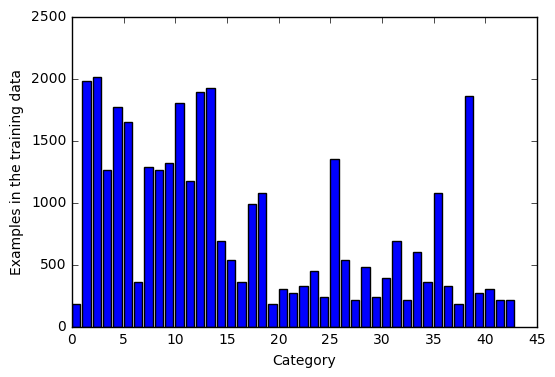

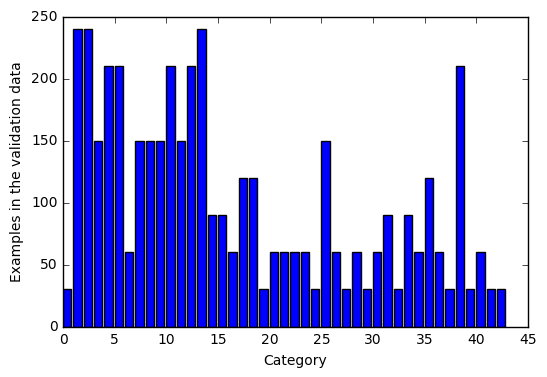

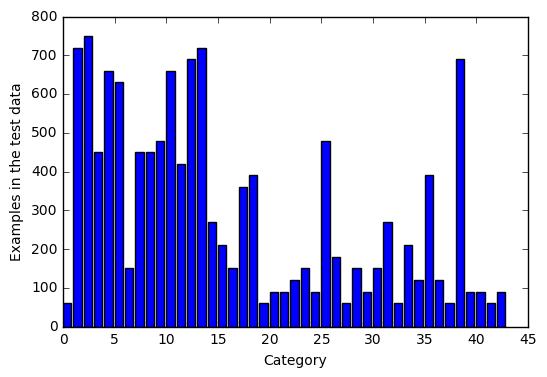

In [10]:
import matplotlib.pyplot as plt

print("Number of training examples   : ", X_train.shape[0])
print("Number of validation examples : ", X_valid.shape[0])
print("Number of testing examples    : ", X_test.shape[0])
print("Image shape                   : ", X_train.shape[1:])
print("----------------")
print("Image Categories")
print("----------------")
for id in categories.keys():
    print( '{:2d}'.format(id), " : ", categories[id] )
    
# Let's determine what percent of each dataset is composed of the each of the categories
def show_stats( y, label ):
    stats = list(range(len(categories)))
    for (i, cat) in enumerate(categories):
        stats[i] = list(y).count(cat)
    fig = plt.figure()
    plt.bar(list(categories.keys()), stats)
    lab = plt.xlabel("Category")
    lab = plt.ylabel("Examples in the " + label + " data")

if plotting:
    show_stats( y_train, "training" )
    show_stats( y_valid, "validation" )
    show_stats( y_test, "test" )

### Example images from each category

In this section, we define a function `display` that will show one image from each category in a given dataset, 
using a passed-in function to determine how to plot an image from the dataset. This lets us easily ask questions like:

- *What do the brightest/darkest images in the dataset look like?*
- *What does the pixel distributions look like for these images?*

In [11]:
import matplotlib.pyplot as plt
import math
from textwrap import wrap 
import numpy as np

def display( X, y, plotter, suptitle ):
    '''
    Show one image from each of the categories available in the specified dataset,
    using the plotter to determine how to plot an image from the dataset. 
    Note that the return value should specify whether to turn the axes off
    '''
    fig     = plt.figure(figsize=(12, 24))
    plt.subplots_adjust(hspace=0.3, top=.96)
    s       = math.floor( math.sqrt(len(categories)) )
    pltCols = 5
    pltRows = math.ceil(len(categories) / pltCols)

    for (i, cat) in enumerate(categories):

        # Get the indices of all of the images of this sign category 
        inds = np.where(y == cat)[0]
        
        # Now use the image_getter to determine which image to show 
        plt.subplot(pltRows, pltCols, i + 1)
        if plotter(X[inds]):
            plt.axis('off')
        title = str(cat) + ": " + categories[cat]
        N = 25
        if len(title) > 25:
            title = title[:23] + "..."
        plt.title( title, fontsize=10 )
    plt.suptitle( suptitle, fontsize=16 ) 

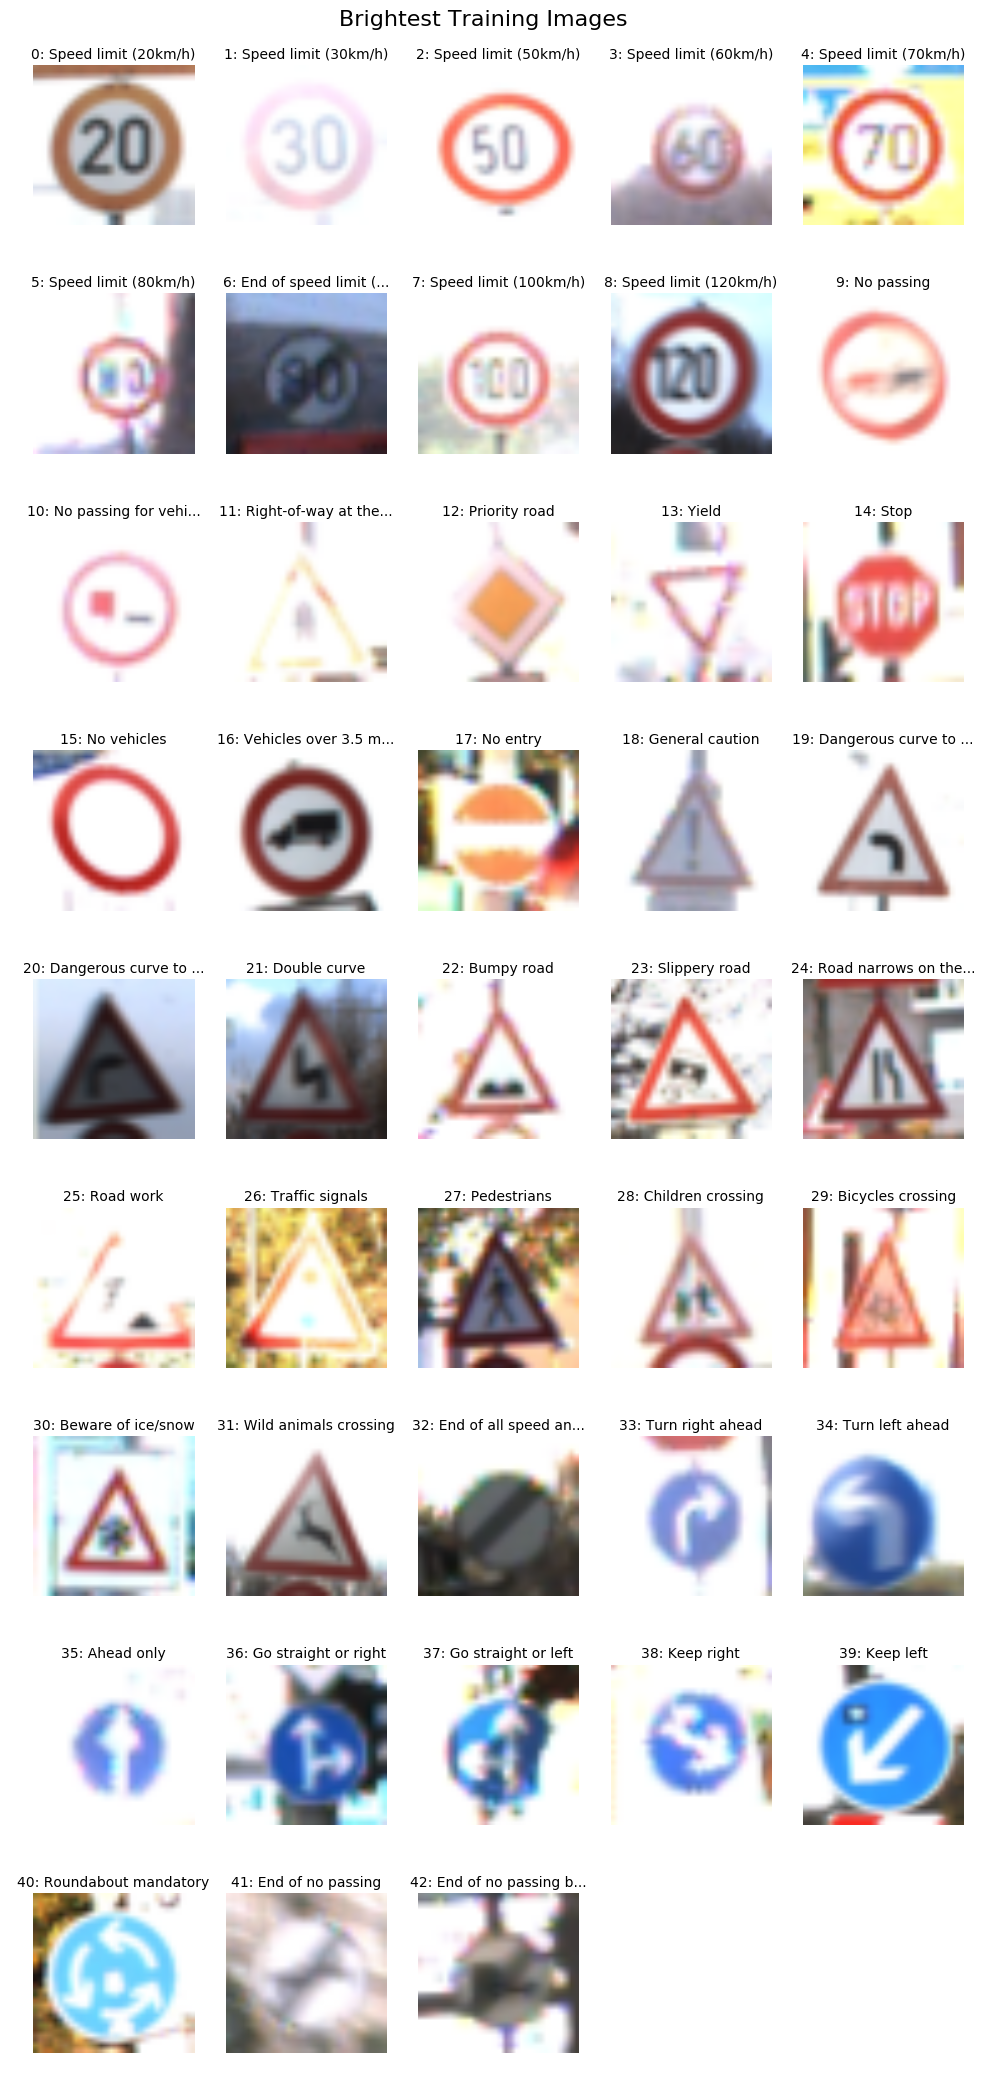

In [12]:
def brightest( X ):
    means = [ np.mean(x) for x in X ]
    plt.imshow(X[np.argmax(means)], vmin=0, vmax=255)
    return True

if plotting:
    display( X_train, y_train, brightest, "Brightest Training Images" )

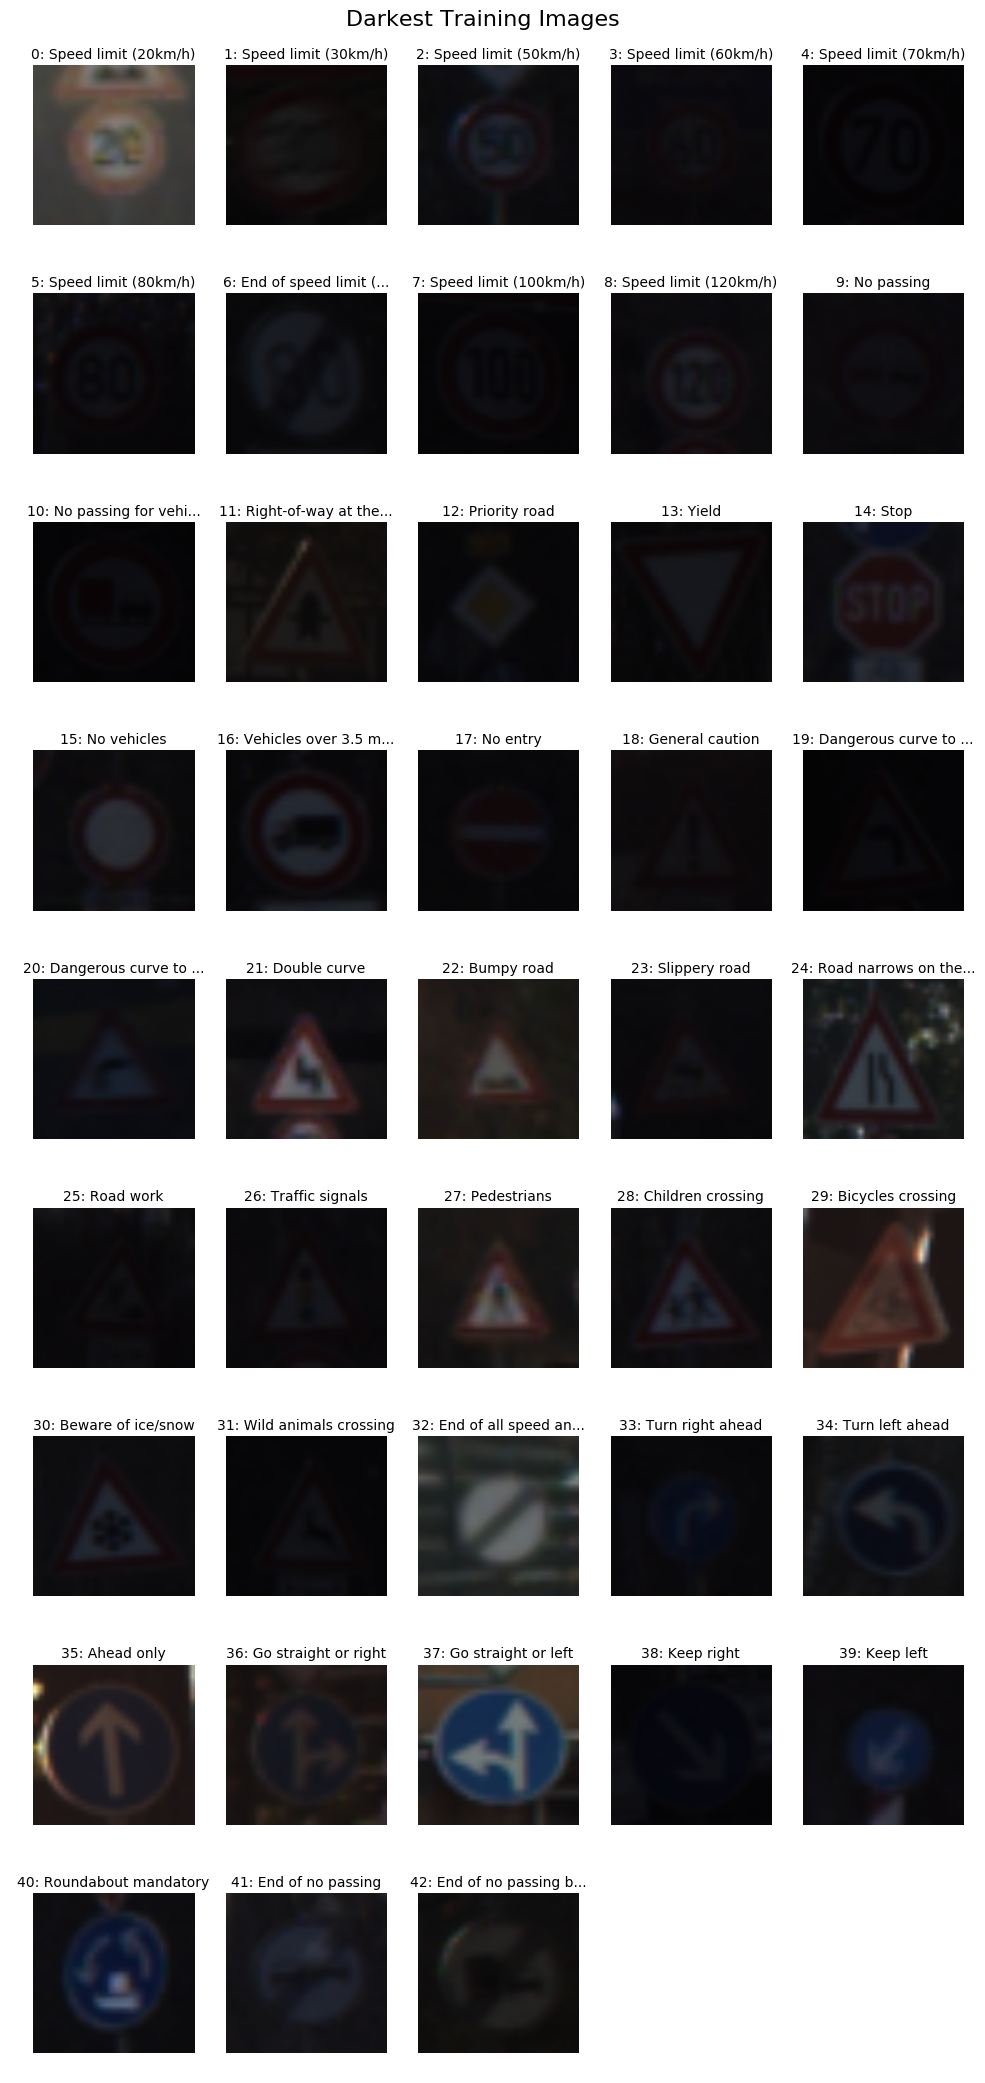

In [13]:
def darkest( X ):
    means = [ np.mean(x) for x in X ]
    plt.imshow(X[np.argmin(means)], vmin=0, vmax=255)
    return True

if plotting:
    display( X_train, y_train, darkest, 'Darkest Training Images' )

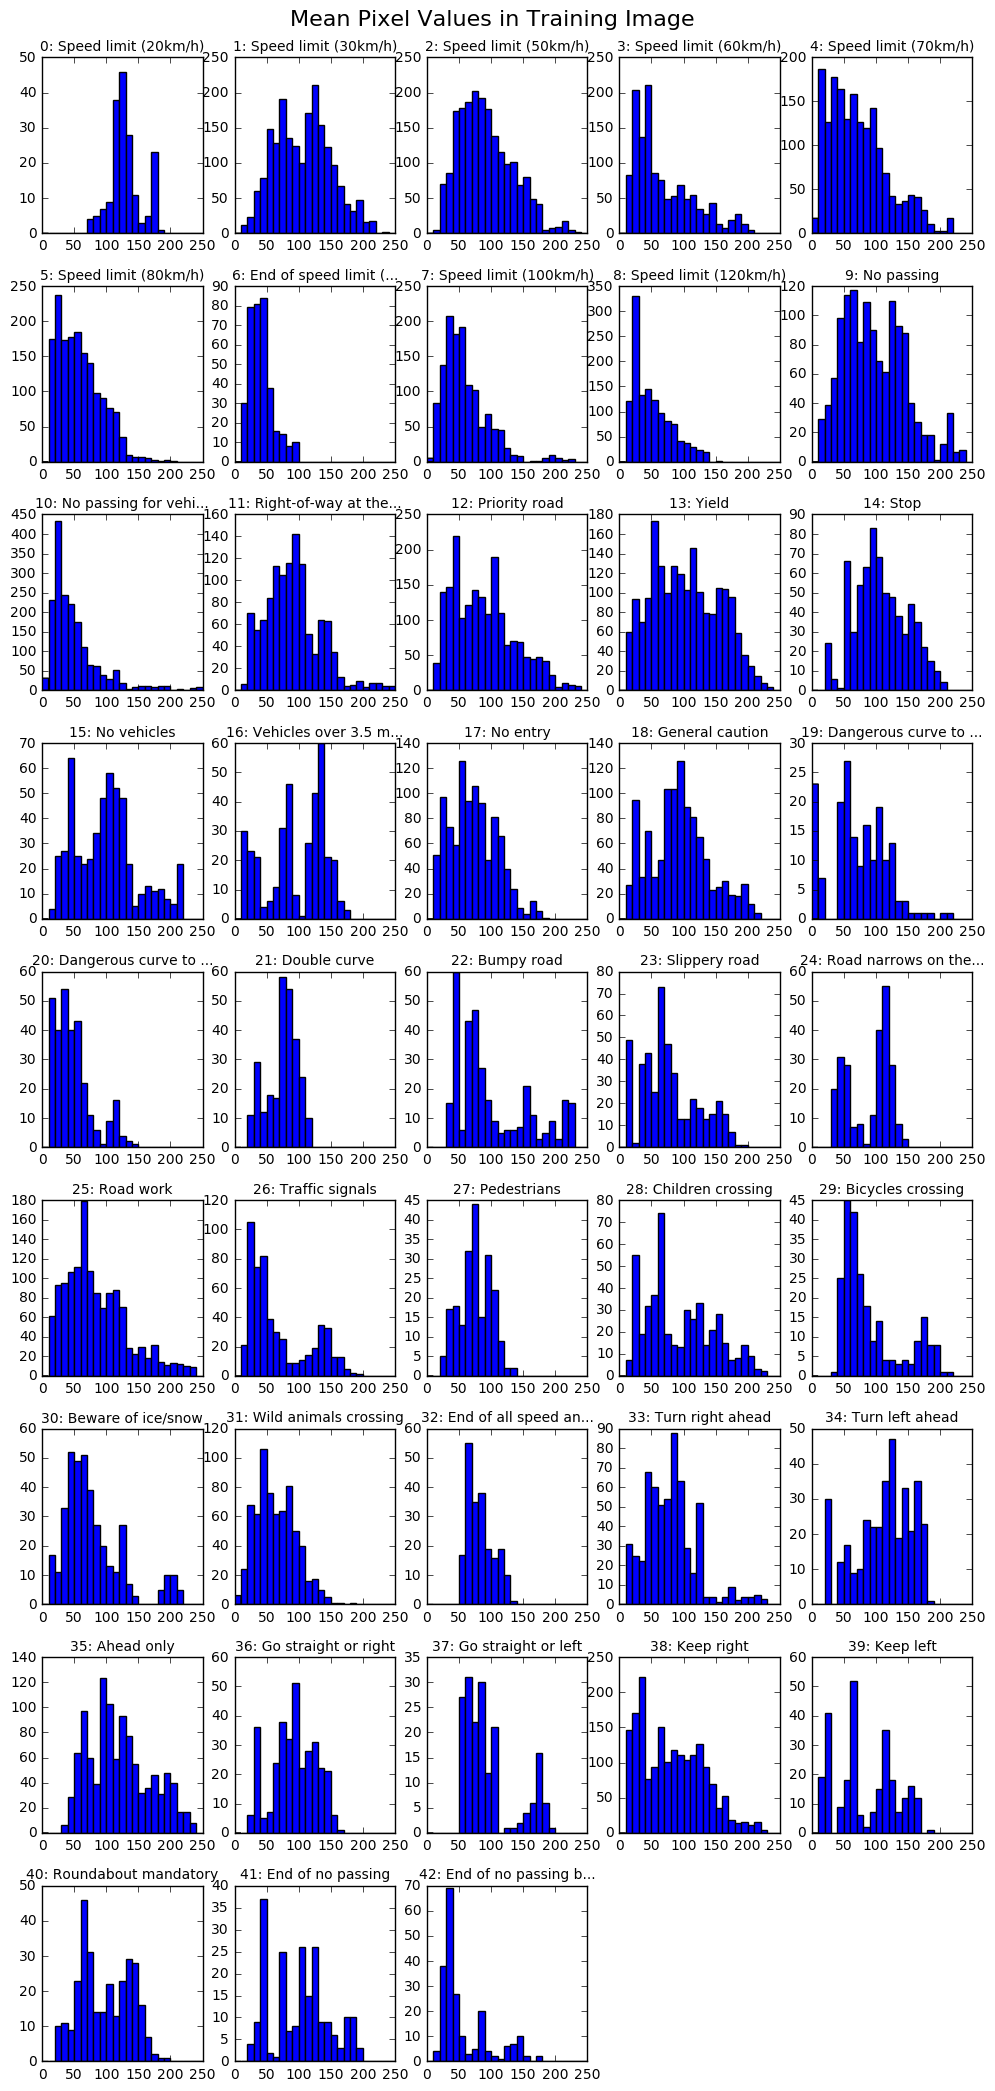

In [14]:
def histograms( X ):
    means = [ np.mean(x) for x in X ]
    plt.hist(means, bins=list(range(0,255,10)))
    return False

if plotting:
    display( X_train, y_train, histograms, 'Mean Pixel Values in Training Image' )

### Discussion

From the previous figures, it seems clear that some of the training data is very dark. In fact, the histograms show us that there are some images with mean pixel values are near 0. We aren't going to do anything about this fact, but it is something to keep in mind. Specifically, you may want to consider removing training images with mean pixel values less than a certain value (like 20 or 30), since they might be doing more harm than good in optimizing the classifier. On the other hand, dark images also appear to be present in the validation and test images (as shown in the following figures), so there is also an argument to keep dark images in the training set.

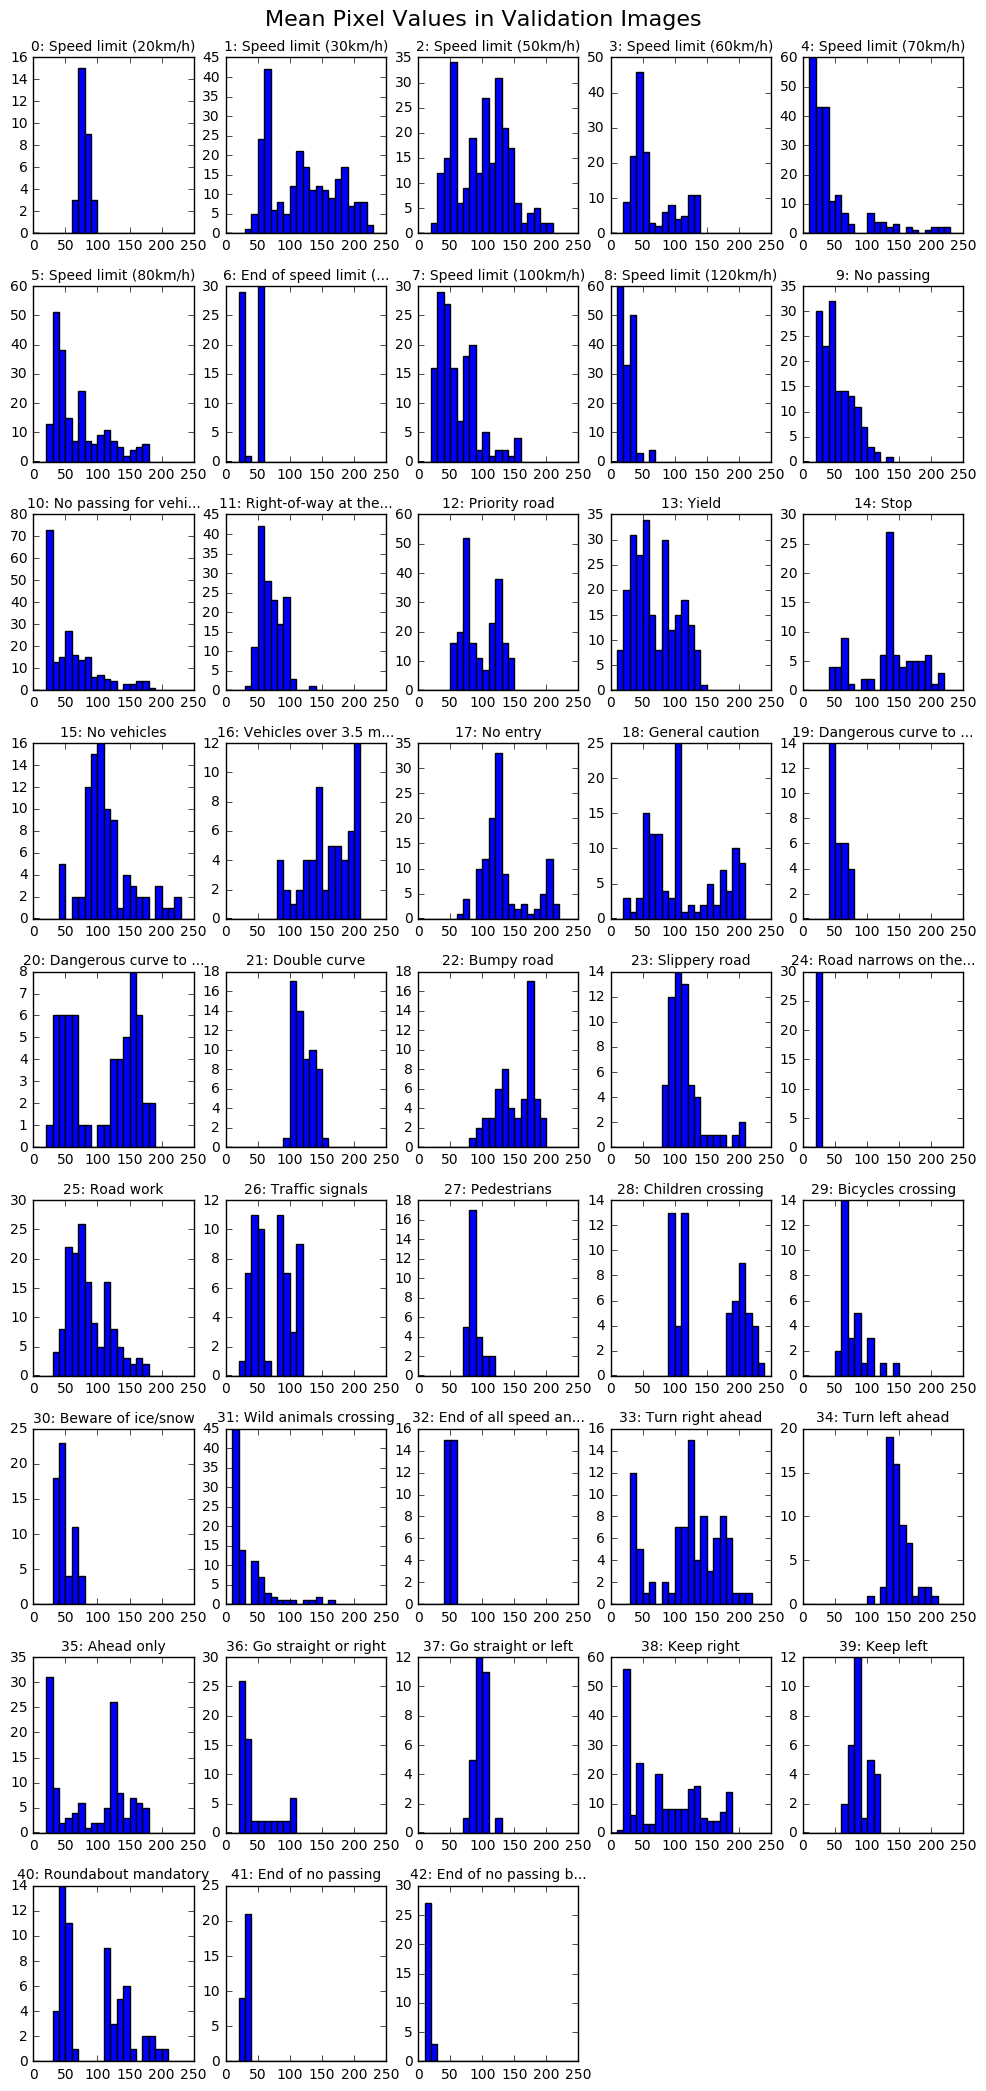

In [15]:
if plotting:
    display( X_valid, y_valid, histograms, 'Mean Pixel Values in Validation Images' )

## Image Preprocessing

In the literature, it is stated that greyscale classifiers tend to perform as well as classifiers which use all three of the RGB color channels. Hence we will convert the images to greyscale. Furthermore, we normalize the greyscale pixels to be in the range `[-1,1]` instead of `[0,255]` before training the data.

In [16]:
import numpy as np 
def grey(x):
    return np.dot(x[...,:3], [0.299, 0.587, 0.114])
    # return np.array([np.mean(y, axis=2) for y in x])

def normalize(x):
    '''
    Normalize image data from [0,255] to [-1, 1]
    '''
    # Move the data from [0,255] to [0,1]
    x = x / 255.0
    # Move the data from [0,1] to [-.5,.5]
    x -= 0.5
    # Move the data from [-.5,.5] to [-1, 1]
    return 2.0 * x

Before: 
[[[18 18 20]
  [19 18 22]
  [15 17 24]
  [18 23 25]]

 [[16 16 17]
  [17 17 21]
  [18 18 24]
  [19 20 23]]

 [[16 15 17]
  [17 17 20]
  [16 17 22]
  [18 20 23]]

 [[19 17 21]
  [17 17 18]
  [16 18 17]
  [16 18 22]]]
After : 
[[-0.85703529 -0.85290196 -0.86509804 -0.8295451 ]
 [-0.87361569 -0.8630902  -0.85345882 -0.8428    ]
 [-0.87821961 -0.86398431 -0.86454118 -0.8451451 ]
 [-0.8584     -0.86577255 -0.86440784 -0.85993725]]


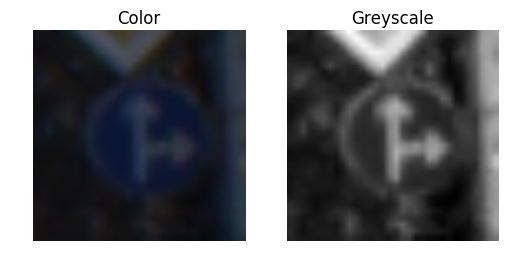

In [17]:
# Convert to greyscale and normalize, making sure we don't run this twice
if X_train.shape[-1] == 3:
    before  = X_train[1000]
    greysc  = grey(X_train)[1000]
    after   = normalize(greysc)
    X_train = normalize(grey(X_train))
    X_valid = normalize(grey(X_valid))
    X_test  = normalize(grey(X_test))
    
# For example, the before and after of one of the images look like this
if plotting:
    fig = plt.figure()
    a = plt.subplot(1,2,1)
    a = plt.axis('off')
    a = plt.title('Color')
    a = plt.imshow( before )

    a = plt.subplot(1,2,2)
    a = plt.axis('off')
    a = plt.title('Greyscale')
    a = plt.imshow( greysc, cmap='gray' )

print("Before: ")
print(before[1:5,1:5])
print("After : ")
print(after[1:5,1:5])

## One-hot Encoding

We will use the `cross_entropy` function in Tensorflow to calculate the cost function. Hence we need to `one-hot` encode the image categories. Although we can do this in Tensorflow, we do this in python code since we will need the one-hot encoded labels practically everywhere.

In [18]:
import numpy as np
def onehot(input):
    '''
    input  : 1D array
    output : one-hot encoded 2D array
    '''
    n   = len(input)
    ids = set(input)
    m   = len(ids)
    output = np.zeros((n, m))

    # Create a dict that maps all of the input values to a unique number from 0... m-1
    # This is primarily important to handle the case where the inputs do not start 
    # at 0 and have a stride of 1, that is, when the inputs are not 0,1,2,3, 
    # but something else, such as 3,4,5 or 3,6,7, etc. 
    idmap = {}
    for i, id in enumerate(ids):
        idmap[id] = i
    newids = [idmap[id] for id in input]

    # Finally, we can create the one-hot encoded values
    output[list(range(n)), newids] = 1
    return output

In [19]:
# One-hot encode the outputs
if len(y_train.shape) == 1:
    y_train_prehot = y_train
    y_train = onehot(y_train)
    y_valid = onehot(y_valid)
    y_test  = onehot(y_test)
    
print("Before one-hot: ", y_train_prehot[0])
print("After one-hot : ", y_train[0])

Before one-hot:  41
After one-hot :  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.]


## Training the LeNet

Finally, we are ready to train our `LeNet` to classify German traffic signs. The `LeNet` class was placed in **`layers.py`** so that it can easily be reused in other projects. To initialize an `LeNet` instance, we must pass an input placeholder of size 

    (None, image width, image height, image channels)
    
and an output placeholder of size 
    
    (None, # of categories)

In [20]:
import layers
import tensorflow as tf 

tf.reset_default_graph()

# Create the placeholder for the input and output data.
x_shape = list(X_train.shape)
x_shape[0] = None
x = tf.placeholder(tf.float32, x_shape)

y_shape = list(y_train.shape)
y_shape[0] = None
y = tf.placeholder(tf.float32, y_shape)

# Create the neural network 
lenet = layers.LeNet(x, y)

Next, to train the network, we create a `trainer` which will be called repeatedly in a loop to train the network. We then pass the training data and trainer to the network's `train` method:

In [21]:
trainer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(lenet.cost)
lenet.train(X_train, y_train, trainer, epochs=5)

Initial    (Accuracy,Cost) : ( 0.00612087 ,  3.80262 )
Epoch: 1 / 5
Training   (Accuracy,Cost) : ( 0.138395 ,  3.477 )
Epoch: 2 / 5
Training   (Accuracy,Cost) : ( 0.229691 ,  3.08753 )
Squared change in variables:  10.6857435834
Epoch: 3 / 5
Training   (Accuracy,Cost) : ( 0.424667 ,  2.36743 )
Squared change in variables:  19.5082367132
Epoch: 4 / 5
Training   (Accuracy,Cost) : ( 0.521365 ,  1.76851 )
Squared change in variables:  18.0750190475
Epoch: 5 / 5
Training   (Accuracy,Cost) : ( 0.62565 ,  1.36728 )
Squared change in variables:  12.9139046849


As shown in the previous step, we can specify the number of epochs that we want to train. After a few epochs, we seem to be doing pretty good. However, an important point to remember is that this is the *training accuracy*. What we should actually be monitoring is the validation accuracy to make sure that we are not overfitting. To do that, we simply need to pass in the validation data as well: 

In [22]:
lenet.train(X_train, y_train, trainer, X_valid=X_valid, y_valid=y_valid, epochs=5)

Initial    (Accuracy,Cost) : ( 0.00669559 ,  3.88549 )
Epoch: 1 / 5
Training   (Accuracy,Cost) : ( 0.122762 ,  3.48942 )
Validation (Accuracy,Cost) : ( 0.100454 ,  3.5434 )
Epoch: 2 / 5
Training   (Accuracy,Cost) : ( 0.182103 ,  3.23851 )
Squared change in variables:  6.41318103556
Validation (Accuracy,Cost) : ( 0.168934 ,  3.32121 )
Epoch: 3 / 5
Training   (Accuracy,Cost) : ( 0.376563 ,  2.72528 )
Squared change in variables:  12.1413631457
Validation (Accuracy,Cost) : ( 0.328345 ,  2.82176 )
Epoch: 4 / 5
Training   (Accuracy,Cost) : ( 0.490761 ,  2.07663 )
Squared change in variables:  15.0664517661
Validation (Accuracy,Cost) : ( 0.436735 ,  2.21564 )
Epoch: 5 / 5
Training   (Accuracy,Cost) : ( 0.564987 ,  1.6376 )
Squared change in variables:  12.3355634784
Validation (Accuracy,Cost) : ( 0.505442 ,  1.78898 )


array([[ 0.01775012,  0.03368362,  0.03842831, ...,  0.01977075,
         0.02116462,  0.0181214 ],
       [ 0.01923869,  0.03405888,  0.03649287, ...,  0.02149194,
         0.02040146,  0.01925184],
       [ 0.01794037,  0.03495177,  0.0389606 , ...,  0.02065828,
         0.02123449,  0.0188095 ],
       ..., 
       [ 0.00589638,  0.01135241,  0.01436716, ...,  0.00908284,
         0.0074073 ,  0.00671368],
       [ 0.00553854,  0.00892004,  0.0105052 , ...,  0.00722534,
         0.00664078,  0.00447032],
       [ 0.00625609,  0.01031949,  0.01253976, ...,  0.00868771,
         0.00895407,  0.00640636]], dtype=float32)

Before doing the full-blown training, we should mention a few other important points... 

1. Did you notice how the training accuracy was different in these two runs? That is because the weights are randomly initialized at the beginning of each training session. To save the model, you must simply specify the `save_to` field in the `train` function, which specifies where to save the model. To load the model from that saved value the next time, you should specify the same value as the `load_from` field. 

1. In addition to the number of epochs, you can change
   - the `keep` probability in the dropout layers `(default=dropout_keep_prob=0.3)`
   - the batch size to use during optimization `(default=batch_size=1024)`

In [23]:
# Try starting from random weights
load_from = None

# Save the model to this file
epochs = 5
save_to = 'checkpoints/lenet0/lenet0'
lenet.train(X_train, y_train, trainer, X_valid=X_valid, y_valid=y_valid, epochs=5, load_from=load_from, save_to=save_to)

Initial    (Accuracy,Cost) : ( 0.0214374 ,  3.76527 )
Epoch: 1 / 5
Training   (Accuracy,Cost) : ( 0.108509 ,  3.44562 )
Validation (Accuracy,Cost) : ( 0.0938775 ,  3.51278 )
Epoch: 2 / 5
Training   (Accuracy,Cost) : ( 0.258111 ,  3.01474 )
Squared change in variables:  10.3710216783
Validation (Accuracy,Cost) : ( 0.207256 ,  3.15338 )
Epoch: 3 / 5
Training   (Accuracy,Cost) : ( 0.435932 ,  2.34021 )
Squared change in variables:  14.5456089751
Validation (Accuracy,Cost) : ( 0.394558 ,  2.49384 )
Epoch: 4 / 5
Training   (Accuracy,Cost) : ( 0.545044 ,  1.74214 )
Squared change in variables:  13.506760178
Validation (Accuracy,Cost) : ( 0.481633 ,  1.90901 )
Epoch: 5 / 5
Training   (Accuracy,Cost) : ( 0.63884 ,  1.366 )
Squared change in variables:  10.5570991063
Validation (Accuracy,Cost) : ( 0.555329 ,  1.55417 )


array([[ 0.0258777 ,  0.03589867,  0.03937185, ...,  0.03068825,
         0.0258527 ,  0.02175316],
       [ 0.02313772,  0.03354176,  0.0366743 , ...,  0.03102868,
         0.0232998 ,  0.02311996],
       [ 0.02836711,  0.04224726,  0.04710505, ...,  0.03427919,
         0.02556617,  0.02299651],
       ..., 
       [ 0.00479177,  0.01318842,  0.0173383 , ...,  0.00610506,
         0.0034387 ,  0.01012294],
       [ 0.00809411,  0.01671768,  0.01695166, ...,  0.00819705,
         0.00656129,  0.0122586 ],
       [ 0.00619626,  0.01414595,  0.01910308, ...,  0.00868366,
         0.00536329,  0.01010448]], dtype=float32)

One question that naturally arises at this point is whether we could do better by simply training the model longer. Fortunately, with our `LeNet` architecture, that is easy to test. We can simply pick up from where the training left off by specifying the `load_from` file to be the previous `save_to` file:

In [24]:
load_from = 'checkpoints/lenet0/lenet0-4'
save_to = 'checkpoints/lenet1/lenet1'
lenet.train(X_train, y_train, trainer, X_valid=X_valid, y_valid=y_valid, epochs=1, load_from=load_from, save_to=save_to)

INFO:tensorflow:Restoring parameters from checkpoints/lenet0/lenet0-4
Loaded from checkpoints/lenet0/lenet0-4
Initial    (Accuracy,Cost) : ( 0.63884 ,  1.366 )
Epoch: 1 / 1
Training   (Accuracy,Cost) : ( 0.70252 ,  1.17589 )
Validation (Accuracy,Cost) : ( 0.635601 ,  1.34264 )


array([[ 0.02089114,  0.02838141,  0.03011652, ...,  0.03177336,
         0.03262205,  0.02706524],
       [ 0.01872774,  0.02742864,  0.02883426, ...,  0.03408571,
         0.02908216,  0.02912239],
       [ 0.02428471,  0.03315914,  0.03483099, ...,  0.03662265,
         0.03488948,  0.03178646],
       ..., 
       [ 0.00367411,  0.01074778,  0.01338732, ...,  0.0041029 ,
         0.0026246 ,  0.00657158],
       [ 0.00615605,  0.01417344,  0.01472219, ...,  0.00615835,
         0.00481492,  0.0080926 ],
       [ 0.00471319,  0.0107632 ,  0.01406141, ...,  0.00605437,
         0.00429002,  0.00705957]], dtype=float32)

To spare the pain of bombarding you with numbers, I then ran the optimizer starting from `checkpoints/lenet/lenet` for 100 epochs, saving the output in `lenet.ckpt`. I will now run the optimizer for one more epoch just so that you can see the training and validation accuracy it is at after all of these runs.

In [25]:
load_from = 'checkpoints/lenet/lenet'
save_to = None
lenet.train(X_train, y_train, trainer, X_valid=X_valid, y_valid=y_valid, epochs=1, load_from=load_from, save_to=save_to)

INFO:tensorflow:Restoring parameters from checkpoints/lenet/lenet
Loaded from checkpoints/lenet/lenet
Initial    (Accuracy,Cost) : ( 0.99635 ,  0.0205435 )
Epoch: 1 / 1
Training   (Accuracy,Cost) : ( 0.995718 ,  0.0243463 )
Validation (Accuracy,Cost) : ( 0.960545 ,  0.156298 )


array([[  9.21400109e-11,   1.48312793e-08,   5.84128752e-12, ...,
          4.02657633e-06,   5.16646385e-01,   8.32836702e-03],
       [  5.94720788e-08,   1.66580162e-06,   2.09067874e-08, ...,
          9.21007813e-05,   3.13590497e-01,   2.52473867e-03],
       [  6.49189556e-12,   3.30143468e-09,   3.44975188e-13, ...,
          1.20421066e-06,   4.82879490e-01,   4.42242948e-03],
       ..., 
       [  1.37483961e-20,   1.47130417e-16,   9.94426421e-16, ...,
          2.25295847e-22,   4.70247877e-18,   1.37798270e-23],
       [  3.99304202e-17,   4.04037901e-14,   1.84697255e-13, ...,
          2.13065221e-19,   2.45837443e-15,   8.52940503e-21],
       [  7.91519435e-20,   5.81812691e-16,   3.85322673e-16, ...,
          3.45365920e-21,   6.54480934e-18,   9.89179353e-24]], dtype=float32)

Finally, let's see how we do on the test set. To do that, just provide the test data to the `train` function, and it will display those values for you as well:

In [26]:
lenet.train(X_train, y_train, trainer, X_valid=X_valid, y_valid=y_valid, X_test=X_test, y_test=y_test, epochs=1, load_from=load_from, save_to=save_to)

INFO:tensorflow:Restoring parameters from checkpoints/lenet/lenet
Loaded from checkpoints/lenet/lenet
Initial    (Accuracy,Cost) : ( 0.99635 ,  0.0205435 )
Epoch: 1 / 1
Training   (Accuracy,Cost) : ( 0.996149 ,  0.0193948 )
Validation (Accuracy,Cost) : ( 0.960091 ,  0.169468 )
Testing    (Accuracy,Cost) : ( 0.946715 ,  0.31224 )


array([[  1.48933253e-12,   5.45910595e-10,   1.75527358e-13, ...,
          3.87458897e-07,   4.52136517e-01,   2.88150972e-03],
       [  7.24744820e-10,   1.18638276e-07,   2.31809971e-09, ...,
          1.25472616e-05,   2.57024050e-01,   7.07883970e-04],
       [  8.31702193e-14,   1.13453143e-10,   6.58202537e-15, ...,
          1.42145282e-07,   3.77692670e-01,   1.43098098e-03],
       ..., 
       [  5.77261319e-21,   4.21642049e-17,   7.36968427e-16, ...,
          8.84819587e-23,   3.95789255e-18,   1.74784487e-23],
       [  5.32281989e-17,   2.86651433e-14,   2.58594009e-13, ...,
          5.06129018e-19,   7.09357821e-15,   3.94820609e-20],
       [  2.78915971e-19,   9.51917014e-16,   1.50014861e-15, ...,
          1.15732649e-20,   2.69702454e-17,   9.99352850e-23]], dtype=float32)

## Augmenting the dataset

To further strain our network, we are going to add more sign categories. Since the source images are not 32x32, the first thing we need to do is resize them.

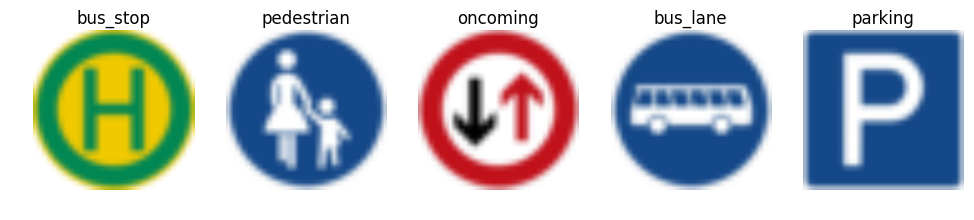

In [27]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import math
import numpy as np

dir       = 'data/augmented/'
files     = os.listdir(dir)
augmented = {}
for i,file in enumerate(files):
    if file.endswith(".p"):
        continue
    im = mpimg.imread(dir + file)
    augmented[file.replace(".jpg","")] = [ scipy.misc.imresize(im, (32,32)), ]

def show_augmented(images, cmap = None, figsize = (12,24) ):
    if figsize is None:
        fig  = plt.figure()
    else:
        fig  = plt.figure(figsize=figsize)
    cols = len(images)
    rows = len(next(iter(images.values())))
    for col,category in enumerate(images):
        ims = images[category]
        for row,im in enumerate(ims):
            plt.subplot(rows,cols, 1 + col + cols * row)
            if cmap is None:
                plt.imshow( im, vmin=0, vmax=255 )
            else: 
                plt.imshow( im, cmap = cmap, vmin=0, vmax=255 )
            plt.axis('off')
            plt.title( category )
            
show_augmented(augmented)

### Discussion 
If we compare these signs to the ones in the original dataset, we see that all of these signs are fairly unique from the original signs. For instance, the `oncoming traffic` sign has one upward and one downward arrow. Only signs 36 and 37 have something comparable, and they have horizontal arrows at that. Similarly, all of the blue signs lack an `edge` around them. We shouldn't focus on the color since we will convert these signs to greyscale, but the signs that may seem comparable have a clear red ring around them, which will still be present in greyscale. Therefore it seems like all of the new signs we have introduced are unique enough to be easily detecable. 

### Generating more data 
Next, we need to generate some training data. Therefore we are going to distort the above images in a myriad of ways in order to give us enough images that we can use for training, validation, and testing. Specifically, if look at the histograms for how many images of each category are present in the datasets, we see that the smallest groups have about:
- 250 training images 
-  50 validation images
- 100 test images

The first thing we can do to distort the images is to modify the brightness. To accomplish this, we will simply multiply the pixels values in the range [0.1, 4.0] with a stride of 0.5.

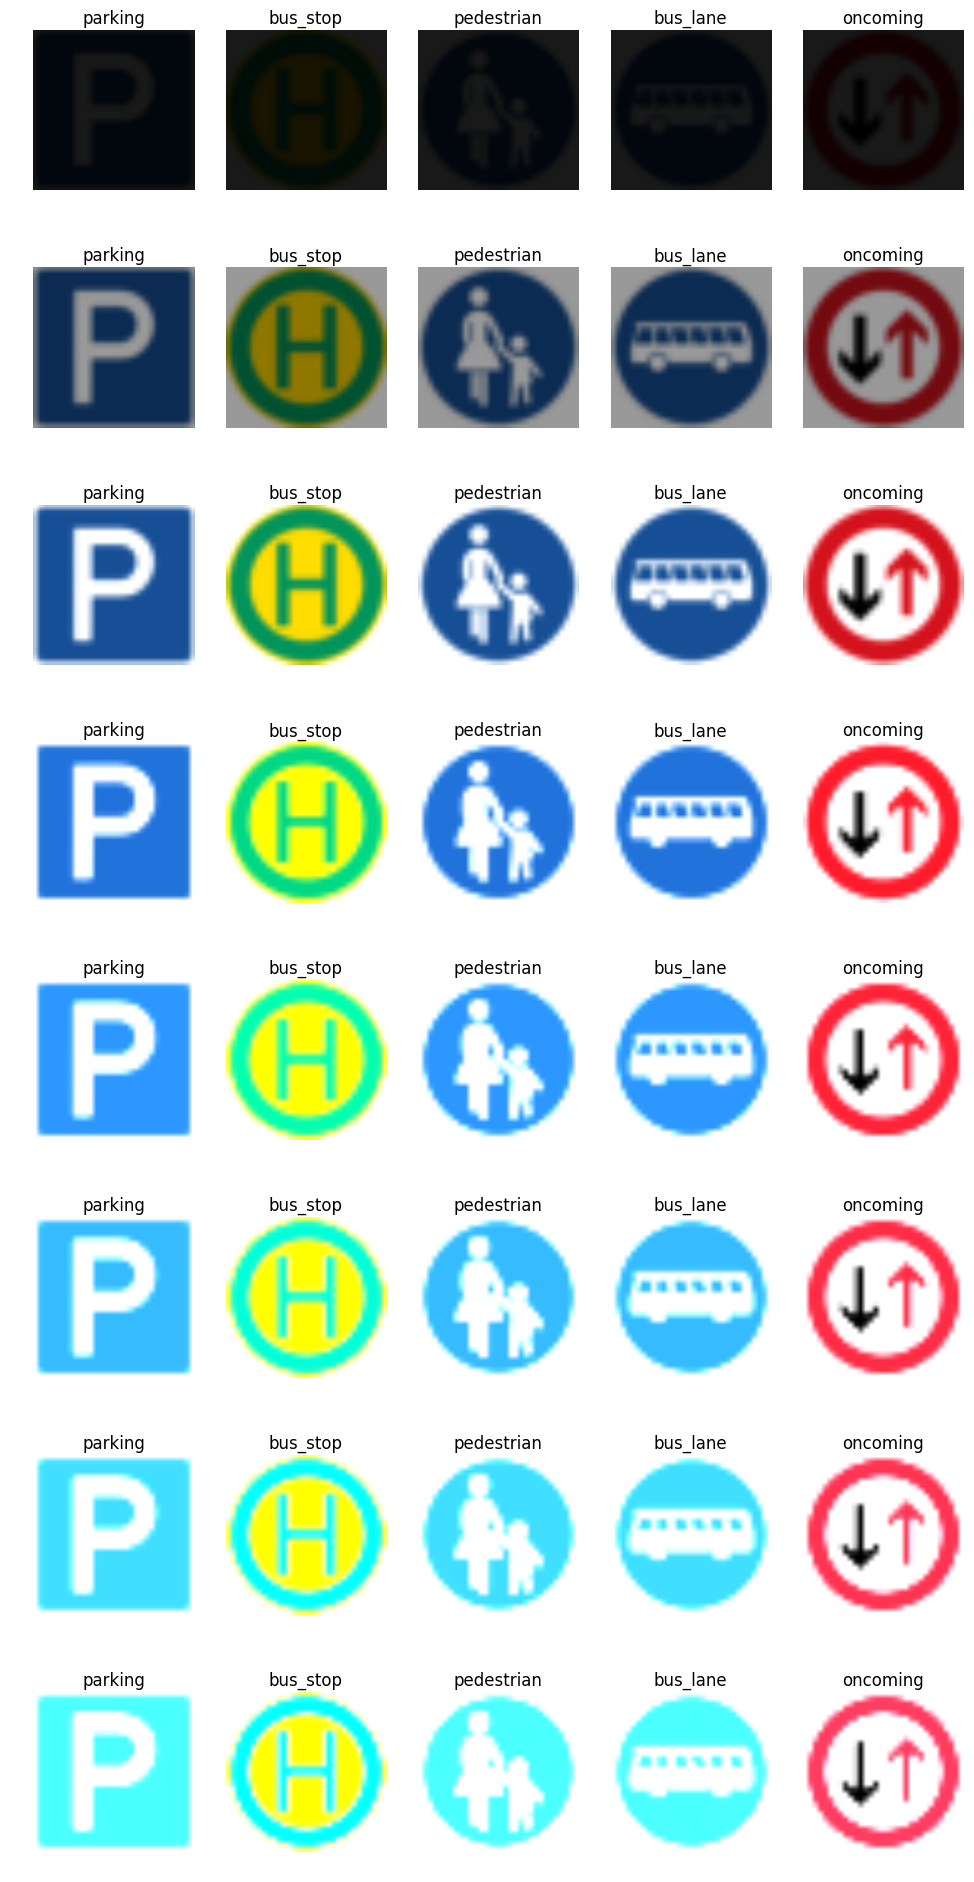

In [28]:
import numpy as np

def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

brightened = dict(augmented)
for cat in augmented:
    original      = np.array(augmented[cat][0])
    brightened[cat] = []
    for brightness in frange( 0.1, 4.0, .5 ):
        brightened[cat].append( np.clip( brightness * np.copy(original), 0, 255 ).astype(np.uint8) )

show_augmented( brightened )

Next, we modify the image scales by multiplying the dimensions from 0.5 to 1.0 with a stride of 0.1, and then placing these images at different locations in the resulting image with a stride of 5 pixels. 

Number of synthetic images per category:  712


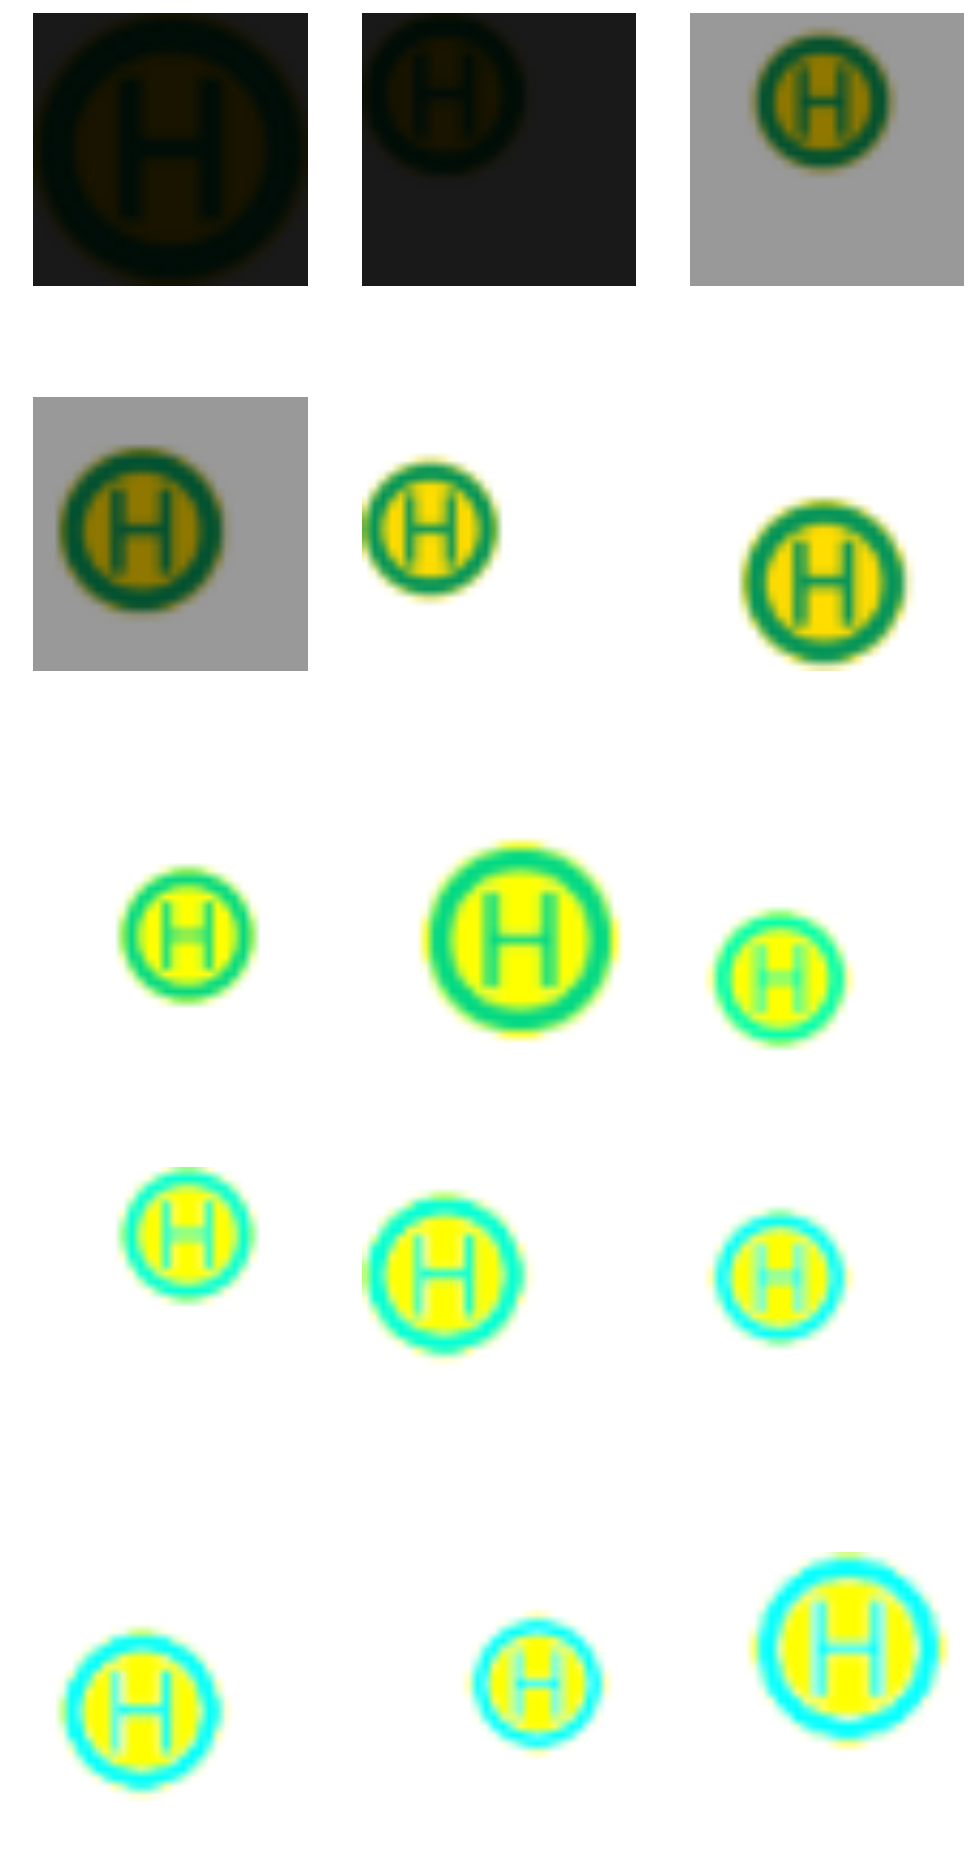

In [29]:
import math
import cv2

# For each of the images, we create a new blank image with the background 
# color equal to the (2,2) entry of the image (just in case there is 
# weirdness at the edges), and then place the original image in the
# blank image. Finally, we resize the result back down to the original size 
imsize   = next(iter(brightened.values()))[0].shape
xstep    = 5
ystep    = 5
resized  = dict(brightened)

for cat in brightened:
    
    originals    = brightened[cat]
    resized[cat] = []
    
    for image in originals:

        resized[cat].append(image)
    
        for scale in frange( 0.5, 1.0, .1 ):
            
            newsize = ( int(imsize[0]/scale), int(imsize[1]/scale), int(imsize[2]) )
            
            for xoff in range( 0, newsize[0] - imsize[0], xstep ):
                
                for yoff in range( 0, newsize[1] - imsize[1], ystep ):
                
                    blank   = np.ones(shape=newsize, dtype=image.dtype) * image[2,2,:]
                    blank[xoff:xoff+imsize[0],yoff:yoff+imsize[1],:] = image
                    resized[cat].append( cv2.resize(blank, imsize[:2]) )
    resized[cat] = np.squeeze(np.array(resized[cat]))

# This leaves us with many more images than we started with:
cat = next(iter(resized.keys()))
print("Number of synthetic images per category: ", len( resized[cat] ) )

def show_all(images, cmap = None, figsize = (12,24) ):
    '''
    The difference between this and show_augmented is that this function accepts a list
    '''
    if figsize is None:
        fig  = plt.figure()
    else:
        fig  = plt.figure(figsize=figsize)
    cols = math.floor( math.sqrt( len(images) ))
    rows = math.ceil( len(images) / cols )
    for i,im in enumerate(images):
        plt.subplot(rows,cols, i+1)
        if cmap is None:
            plt.imshow( im, vmin=0, vmax=255 )
        else: 
            plt.imshow( im, cmap = cmap, vmin=0, vmax=255 )
        plt.axis('off')

show_all( resized[cat][0::50])

Finally, before augmenting our original dataset, we are going to shuffle the data, generate labels, and break everything up into training, validation, and testing datasets using a (60,10,30) rule:

In [30]:
import random

for key in resized.keys():
    random.shuffle(resized[key])

def splitter(dataset):
    a = math.floor( len(dataset) * .6 )
    b = math.floor( len(dataset) * .7 )
    return dataset[:a], dataset[a:b], dataset[b:]

X_traina = []    
y_traina = []    
X_valida = []    
y_valida = []    
X_testa  = []    
y_testa  = []    
for i,cat in enumerate(resized):
    
    # Split the data. 
    train, valid, test = splitter(resized[cat])
    X_traina.extend(train)
    X_valida.extend(valid)
    X_testa.extend(test)
    
    # Create the labels
    n = len(categories) + i
    y_traina.extend(n * np.ones(len(train),int))
    y_valida.extend(n * np.ones(len(valid),int))
    y_testa.extend(n * np.ones(len(test),int))
    
print("New Training data  : ", np.array(X_traina).shape)
print("New Training labels: ", np.array(y_traina).shape)
print("New Training data  : ", np.array(X_valida).shape)
print("New Training labels: ", np.array(y_valida).shape)
print("New Training data  : ", np.array(X_testa).shape)
print("New Training labels: ", np.array(y_testa).shape)

New Training data  :  (2135, 32, 32, 3)
New Training labels:  (2135,)
New Training data  :  (355, 32, 32, 3)
New Training labels:  (355,)
New Training data  :  (1070, 32, 32, 3)
New Training labels:  (1070,)


Next, we want add the data to the original dataset, greyscale it, and normalize it. Furthermore, we add the labels to the original labels and then convert them to one-hot. 

In [31]:
X_train = np.concatenate( ( X_train_original, X_traina ) )
X_valid = np.concatenate( ( X_valid_original, X_valida ) )
X_test  = np.concatenate( ( X_test_original,  X_testa  ) )

# Convert to greyscale and normalize, making sure we don't run this twice
if np.array(X_train).shape[-1] == 3:
    X_train = normalize(grey(X_train))
    X_valid = normalize(grey(X_valid))
    X_test  = normalize(grey(X_test))

y_train = np.concatenate( ( y_train_original, y_traina ) )
y_valid = np.concatenate( ( y_valid_original, y_valida ) )
y_test  = np.concatenate( ( y_test_original,  y_testa  ) )

# One-hot encode the outputs
if len(y_train.shape) == 1:
    y_train = onehot(y_train)
    y_valid = onehot(y_valid)
    y_test  = onehot(y_test) 

Optionally, you can repickle the data at this point so that you can start off from exactly this point. 

In [32]:
pickling = True
if pickling:
    folder = 'data/augmented/'
    data = {}
    data['features'] = X_train
    data['labels']   = y_train
    with open(folder + 'train.p', 'wb') as f:
        pickle.dump(data, f)
    data['features'] = X_valid
    data['labels']   = y_valid
    with open(folder + 'valid.p', 'wb') as f:
        pickle.dump(data, f)
    data['features'] = X_test
    data['labels']   = y_test
    with open(folder + 'test.p', 'wb') as f:
        pickle.dump(data, f)

## Retraining 

Since the number of output labels changed, we have to restart the training. 

In [33]:
import layers
import tensorflow as tf 

# Reset the graph before creating another LeNet. Resetting is important for saving
tf.reset_default_graph()

# Detect if we are trying to start form this cell. In this case, try to use pickled data 
X_train, y_train, X_valid, y_valid, X_test, y_test = loadfrom("data/augmented/")

# Create the placeholder for the input and output data.
x_shape = list(X_train.shape)
x_shape[0] = None
x = tf.placeholder(tf.float32, x_shape)

y_shape = list(y_train.shape)
y_shape[0] = None
y = tf.placeholder(tf.float32, y_shape)

lenetUpdated = layers.LeNet(x, y)

Like before, I have pretrained this network for you. But I will run one more iteration with it just so that you can see the training, validation, and testing accuracies... 

In [34]:
load_from = 'checkpoints/lenetAugmented/lenetAugmented'
save_to = None
trainerUpdated = tf.train.AdamOptimizer(learning_rate=0.001).minimize(lenetUpdated.cost)
lenetUpdated.train(X_train, y_train, trainerUpdated, X_valid=X_valid, y_valid=y_valid,  X_test=X_test, y_test=y_test, epochs=1, load_from=load_from, save_to=save_to);

INFO:tensorflow:Restoring parameters from checkpoints/lenetAugmented/lenetAugmented
Loaded from checkpoints/lenetAugmented/lenetAugmented
Initial    (Accuracy,Cost) : ( 0.946473 ,  0.350946 )
Epoch: 1 / 1
Training   (Accuracy,Cost) : ( 0.953756 ,  0.125164 )
Validation (Accuracy,Cost) : ( 0.898636 ,  0.326708 )
Testing    (Accuracy,Cost) : ( 0.884306 ,  0.418176 )


Like with the original dataset, we see a training, validation, and testing accuracies in the high 90s. However, in this case, the larger dataset is probably the reason for the training inaccuracies. 

## An examination of classification probabilities

The last things we want to examine are the classification probabilities. We will do this in order to get a better understanding of how confident the network is in its predictions. Specifically, suppose we have 100 validation images of a stop sign. For each image, the network produces a probability that the image is a stop sign, a `30 km/h` sign, etc. We will average these probabilities across all 100 images and put the results in a bar graph. This bar graph should give us a better understanding of how confident the network is when it sees a stop sign. Furthermore, we show these plots for each of the image types. 

Before we show you the probabilities, you should reflect for a second on why we are doing this... 

The reason is simply that probabilities can reveal a drastically different picture than predictions. In an ideal world, the network would say that a stop sign is a stop sign with probability 1. That will never happen in practice. However, we WOULD like the probability to be high. Just examining the predictions can itself be a misleading metric. For instance, it could turn out that the network is assigning a 10% probability that a stop sign is a stop sign. That is not a very confident prediction at all. However, this could still result in the correct prediction if all of the other prediction values are smaller. Thus if we just look at the prediction we would think that our network is doing much better than it actually is. Anyway... on to the results. 

In [35]:
load_from = 'checkpoints/lenetAugmented/lenetAugmented'
save_to = None
softmax = lenetUpdated.train(X_train, y_train, trainerUpdated, X_valid=X_valid, y_valid=y_valid,  X_test=X_test, y_test=y_test, epochs=1, load_from=load_from, save_to=save_to)

INFO:tensorflow:Restoring parameters from checkpoints/lenetAugmented/lenetAugmented
Loaded from checkpoints/lenetAugmented/lenetAugmented
Initial    (Accuracy,Cost) : ( 0.946473 ,  0.350946 )
Epoch: 1 / 1
Training   (Accuracy,Cost) : ( 0.951265 ,  0.124725 )
Validation (Accuracy,Cost) : ( 0.899895 ,  0.325205 )
Testing    (Accuracy,Cost) : ( 0.881605 ,  0.427176 )


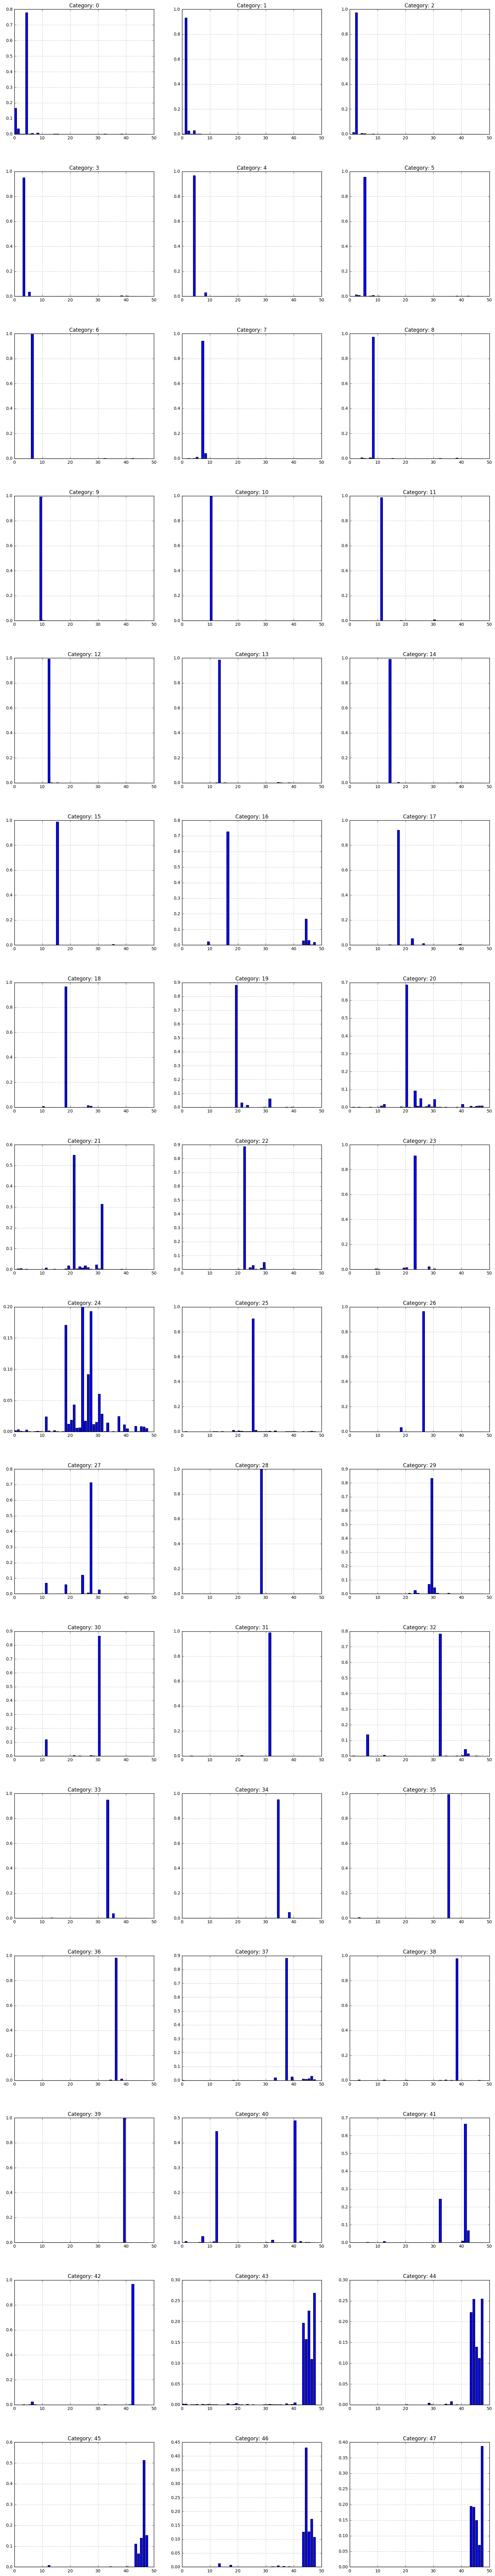

In [37]:
import matplotlib.pyplot as plt
import math 

X = X_valid
y = y_valid
truth = np.argmax(y,axis=1)
cats = np.max(truth) + 1

fig = plt.figure(figsize=(20,100))
plt.subplots_adjust(hspace=0.3, top=.96)
cols = 3
rows = math.ceil(cats / cols)
x_ax = list(range(cats))
for cat in range(cats):
    
    # Now extract only the probabilities for this specific category
    inds = np.where(truth == cat)[0]
    average_probabilities = np.mean( softmax[inds], axis = 0 )
    
    ax = plt.subplot( rows, cols, cat+1)
    plt.bar(x_ax, average_probabilities)
    ax.grid()
    plt.title("Category: " + str(cat))

## Discussion

For the most part, the network seems to yield fairly high prediction accuracies. But there are indeed some problems. 

- First of all, of the 5 new image classes we introduced, the network classifies categories 44 and 46 fairly easily, but seems to be having significant problems ditinguishing the other three images. Let's look at some of those examples to see what is going on: 

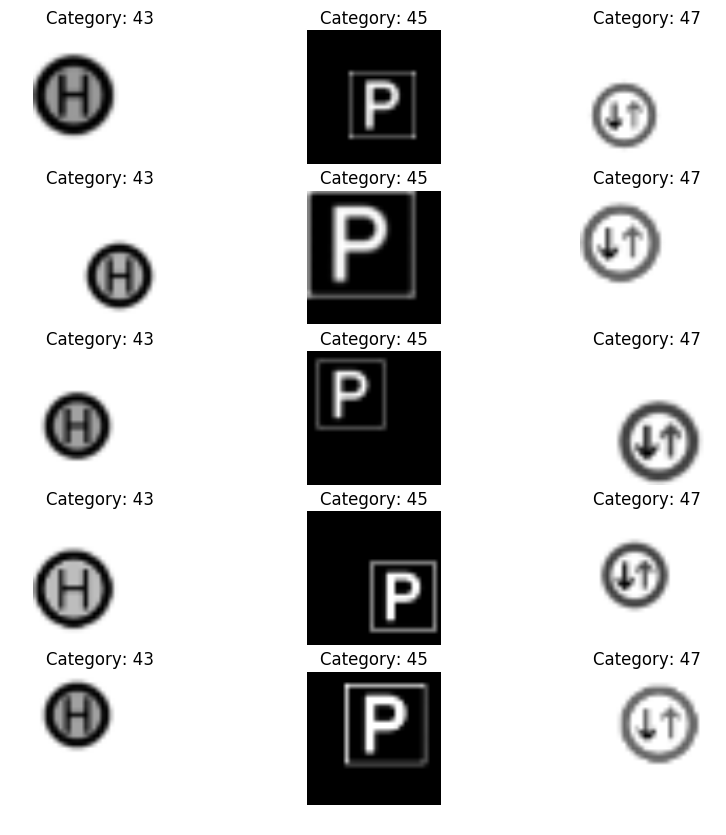

In [38]:
def show_images(cats):
    fig = plt.figure(figsize=(10,10))
    cols = len(cats)
    rows = 5
    for i,cat in enumerate(cats):

        # Now extract only the probabilities for this specific category
        inds = np.where(truth == cat)[0]
        for j,x in enumerate(X[inds[:rows]]):
            ax = plt.subplot( rows, cols, i+j*cols+1)
            plt.imshow(x,cmap="gray")
            plt.axis('off')
            plt.title("Category: " + str(cat))
if plotting: 
    show_images([43,45,47])

Hmm. Very strange indeed. I believe that the most likely scenario is that the network has decided that for these images, it will simply look for a dark circle. Perhaps due to the fact that these are synthetic images, the network can easiyl distinguish these images from the `real` photographs, and then simply looks for a circle to classify it. Fortunately the predictions turn out to be correct. However, I think we would need to inject a lot more non-synthetic data if we want to improve the accuracy here. 

There are two more things we will look into before saying our goodbyes:

1. The predictions for category 40 are horrible. The network seems to have a hard time distinguishing it from category 12. This is likely the result of bad images for category 40. We suspect this is the case because if the network legitimately had a hard time distinguishing categories 12 and 40, then you would see the same thing happening for the predictions for category 12. 
2. A similar thing seems to be happening for the category 24 images. Specifically, it seems to have a hard time telling with a category 24 image belongs to category 18, 24, or 27. Again, since we don't see reciprocal behavior in the category 18 or 27 images, I would suspect that the category 24 images are simply poor quality. 

Let's see how wrong I am... 

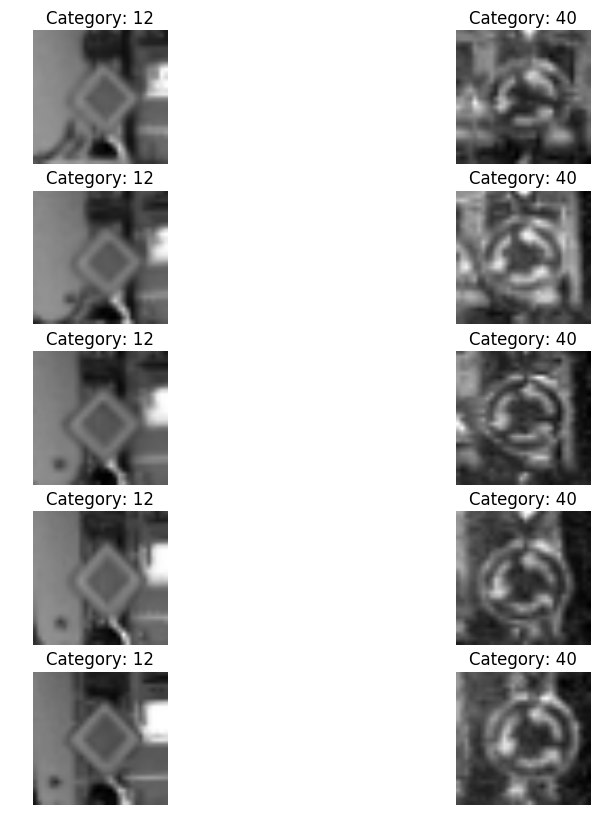

In [39]:
if plotting: 
    show_images([12,40])

Woops! That prediction seems to be wrong. Comparing these images, it seems like the likely source of the problem is that the background for the category 40 images contains diamonds like the category 12 signs. When doing image classification, you always have to watch out for those busy backgrounds! 

What about our other prediction?

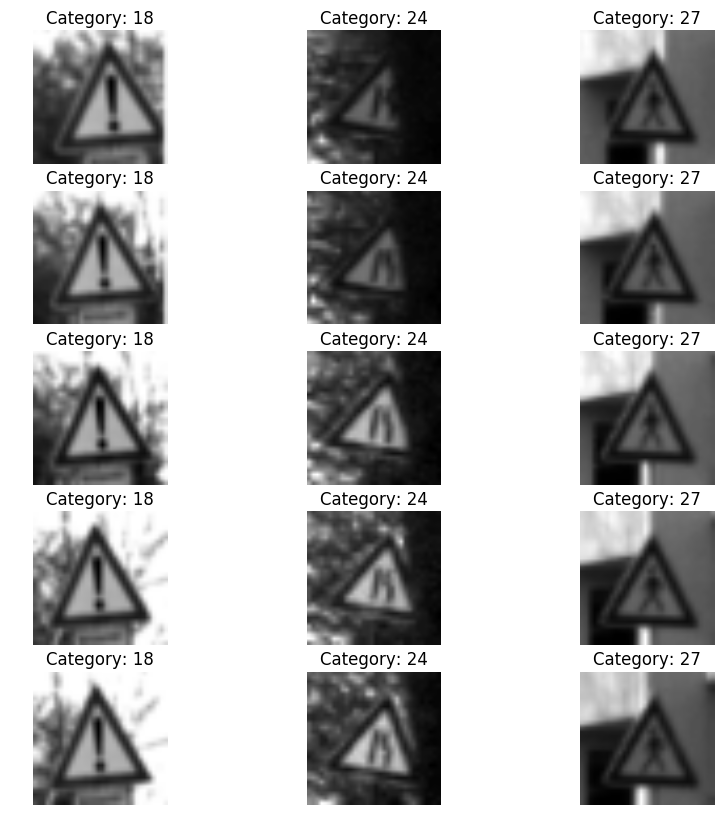

In [40]:
if plotting: 
    show_images([18,24,27])

Aha. In this case it should be easy to understand the confusion... If the images are too blurry, then all of these start to look like a single line in an upward-facing triangle. More data will likely solve this problem.